In [1]:
using BayesNets

# Usage for Markov Fields

## Basic Usage

A Markov Field is represented as an MRF type containting an undirected graph modeling the conditional independence of the joint probability distribution. Each node is associated to a name, and an MRF contains a list of `Factor`s, who represent the probability distribution. The joint probability distribution is the product of all the `Factor`s. 

So far this only supports discrete distributions. Priority to extend this to Gaussian models.

To build an MRF, the recommended way is simply to construct factors, then to call the MRF constructor with a list of factors. The constructor will then build the representation of the MRF (i.e. an edge will be added between all nodes that are featured in common factors).

In [2]:
f = Factor([:a, :b], [2, 2])
g = Factor([:b, :c], [2, 2])
factors = [f, g]
mrf = MRF(factors)

Note - this is indeed an UG graph. Looks like TikzGraphs doesn't support undirected graphs, but looks like an easy fix

## Sampling
Sampling in MRFs is done through *Gibbs Sampling*. We will use as a basic example an Ising model. 

For this we need to build a 'grid' graph. We then use the graph to create the list of associated factors. Each node is has two possible values, `1` or `2`. The factors are pairwise and reflect that two neighboring nodes have a tendency to align.

### Ising Model

In [2]:
using LightGraphs # we need this to build our factor list.
using Plots
gr(size = (300,300), scale = 1)

Plots.GRBackend()

Building the Grid:

In [4]:
n = 32
grid = Grid([n,n])

{1024, 1984} undirected graph

In [6]:
interact = .7 # this is our interaction energy

# we then define the factor matrix:
interact_array = [exp(interact) exp(-interact);
                  exp(-interact) exp(interact)]

factors = Array{Factor}(length(edges(grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(grid))
    factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
end

mrf = MRF(factors);


In [14]:
# creating the sampler object - right now the Givvs sampler is the only one available
sampler = MRFGibbsSampler(Assignment(), burn_in = 0)

BayesNets.MRFGibbsSampler(Dict{Symbol,Any}(),0,0,Nullable{Dict{Symbol,Any}}())

In [8]:
# the running the sampler - this can take a while
iters = 200
@time df = rand(mrf, sampler, iters);

 57.087385 seconds (138.45 M allocations: 24.755 GB, 7.93% gc time)


In [13]:
# some code to look at our Ising Model
orderednames = [Symbol(i) for i in 1:length(vertices(grid))]
a = reshape(convert(Array{Float64},df[1,orderednames]), (n, n) )
plt = heatmap(a, axis = nothing)

@gif for i=1:iters
    a = reshape(convert(Array{Float64}, df[i,orderednames]), (n, n))
    heatmap!(a, axis = nothing)
end

INFO: Saved animation to /Users/henripal/.julia/v0.5/BayesNets/doc/tmp.gif


Plots.AnimatedGif("/Users/henripal/.julia/v0.5/BayesNets/doc/tmp.gif")

### Potts Model
Since this framework is flexible in terms of the interactions, it is easy to build more complicated models using the same procedure. For example we can build a 4 color Potts model on a grid in the same manner:

In [19]:
interact = .7 # this is our interaction energy

# This is the only difference from our previous example ###
interact_array = [exp(interact) exp(-interact) exp(-interact) exp(-interact);
                  exp(-interact) exp(interact) exp(-interact) exp(-interact);
                  exp(-interact) exp(-interact) exp(interact) exp(-interact);
                  exp(-interact) exp(-interact) exp(-interact) exp(interact)]
    
factors = Array{Factor}(length(edges(grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(grid))
    factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
end

mrf = MRF(factors);

In [20]:
# the running the sampler - this can take a while
iters = 200
@time df = rand(mrf, sampler, iters);

 59.825705 seconds (136.40 M allocations: 24.707 GB, 9.63% gc time)


In [21]:
# some code to look at our Potts Model
orderednames = [Symbol(i) for i in 1:length(vertices(grid))]
a = reshape(convert(Array{Float64},df[1,orderednames]), (n, n) )
plt = heatmap(a, axis = nothing)

@gif for i=1:iters
    a = reshape(convert(Array{Float64}, df[i,orderednames]), (n, n))
    heatmap!(a, axis = nothing)
end

INFO: Saved animation to /Users/henripal/.julia/v0.5/BayesNets/doc/tmp.gif


Plots.AnimatedGif("/Users/henripal/.julia/v0.5/BayesNets/doc/tmp.gif")

## Inference
Here we use the MRF to denoise a black and white image - the idea is that the MRF is still a grid, and that the interactions between neighbors still encourages local coherence, but now we connect an extra node to each node on the grid, corresponding to the value of the pixel. The ground state will then correspond to an image with 
* local coherence
* close to the target image

In [22]:
using Images, TestImages, Distributions, LightGraphs, BayesNets

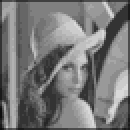

In [23]:
n_levels = 20
img = restrict(restrict(testimage("lena_gray_256")))
im_size = size(img)[1]
img_data = convert(Array{Int}, round(n_levels.*Images.data(img)))
grayim(img_data/n_levels)

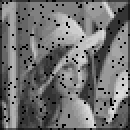

In [24]:
noisy_img_data = img_data  .*rand(Bernoulli(.94),im_size,im_size)
grayim(noisy_img_data/n_levels)

In [31]:
interact_neighbor = .3 # this is our interaction energy
interact_data = .9

# creating the grid copied on image size
new_grid = Grid([im_size,im_size])
    
interact_array = fill(exp(-interact_neighbor), n_levels, n_levels) + (exp(interact_neighbor) -exp(-interact_neighbor))* eye(n_levels)
interact_data = fill(exp(-interact_data), n_levels, n_levels) + (exp(interact_data) -exp(-interact_data))* eye(n_levels)


20×20 Array{Float64,2}:
 2.4596   0.40657  0.40657  0.40657  …  0.40657  0.40657  0.40657  0.40657
 0.40657  2.4596   0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  2.4596   0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  2.4596      0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657  …  0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657  …  0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 0.40657  0.40657  0.40657  0.40657     0.40657  0.40657  0.40657  0.40657
 

In [32]:
add_vertices!(new_grid, im_size*im_size)

true

In [33]:
for i in 1:(im_size*im_size)
    add_edge!(new_grid, i, i+im_size*im_size)
end

In [34]:
factors = Array{Factor}(length(edges(new_grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(new_grid))
    if (e[1]>=im_size*im_size) || (e[2]>=im_size*im_size)
        factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_data)
    else
        factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
    end
end

mrf = MRF(factors);

In [35]:
# creating the sampler object - right now the Givvs sampler is the only one available
img_nodes = [Symbol(i) for i in (im_size*im_size+1):(2*im_size *im_size)]
img_values = noisy_img_data[:]
assgn = Assignment(zip(img_nodes, img_values))
sampler = MRFGibbsSampler(assgn, burn_in = 0)

BayesNets.MRFGibbsSampler(Dict{Symbol,Any}(Pair{Symbol,Any}(Symbol("5705"),9),Pair{Symbol,Any}(Symbol("8231"),12),Pair{Symbol,Any}(Symbol("7798"),8),Pair{Symbol,Any}(Symbol("4275"),6),Pair{Symbol,Any}(Symbol("8298"),13),Pair{Symbol,Any}(Symbol("7210"),17),Pair{Symbol,Any}(Symbol("6861"),12),Pair{Symbol,Any}(Symbol("5433"),15),Pair{Symbol,Any}(Symbol("7243"),5),Pair{Symbol,Any}(Symbol("5902"),4)…),0,0,Nullable{Dict{Symbol,Any}}())

In [38]:
iters = 200
@time df = rand(mrf, sampler, iters);

 74.140782 seconds (80.82 M allocations: 50.862 GB, 13.19% gc time)


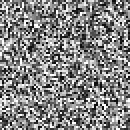

In [39]:
# some code to look at our Potts Model
orderednames = [Symbol(i) for i in 1:(im_size*im_size)]
a = reshape(convert(Array{Float64},df[20,orderednames]), (im_size, im_size) )
rebuiltim = grayim(a/n_levels)

In [31]:
size(img_nodes)

(4225,)

In [32]:
size(noisy_img_data[:])

(4225,)